In [1]:
import gzip
import glob
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbilr.reader import MatrixReader

runs = ["20220708_GM12878", "20220708_GM12878R2", "20220817_HG001", "20220915_P1", "20220916_P1", "20220916_P2"]

# Demultiplexing

## 1. Distribution of barcode edit distance

0    51.305086
1    13.144824
2     9.023654
3     5.696887
4     3.748836
5     2.585833
6     2.966424
7     7.267369
8     4.115230
9     0.145855
dtype: float64
Perfect barcode ratio: 51.305086
Base precision: 0.972576


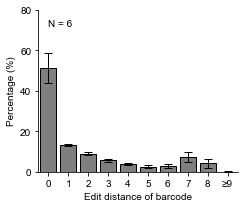

In [2]:
max_ed = 9
rows = []
for run in runs:
    path = "../../1_NanoStrandSeq/results/demux/fbilr/%s.stats.tsv.gz" % run
    d = pd.read_csv(gzip.open(path), sep="\t", header=None)
    d.columns = ["Barcode1", "Direction1", "Location1", "ED1", "Barcode2", "Direction2", "Location2", "ED2", "Count"]
    counter = defaultdict(int)
    for ed1, ed2, count in d[["ED1", "ED2", "Count"]].values:
        assert ed1 >= 0 and ed2 >= 0
        counter[ed1] += count
        counter[ed2] += count
    row = [counter[x] for x in range(0, max_ed)]
    row.append(sum(counter.values()) - sum(row))
    rows.append(row)
d = pd.DataFrame(rows)
d.index = runs
d = d.divide(d.sum(axis=1), axis=0) * 100

ys = d.mean(axis=0)
print(ys)
yerr = d.std(axis=0)
xs = np.arange(len(ys))
ticks = [str(x) for x in xs]
ticks[-1] = "≥%s" % ticks[-1]
print("Perfect barcode ratio: %f" % ys[0])
print("Base precision: %f" % (ys[0] / 100) ** (1/24))
ylim = 80

plt.figure(figsize=(3.5, 3))
plt.bar(xs, ys, yerr=yerr, lw=1, capsize=4, width=0.8, color="C7", edgecolor="black", error_kw={"lw": 1})
plt.text(0, ylim * 0.9, "N = %d" % len(runs))
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, ylim)
plt.xticks(xs, ticks)
plt.yticks(np.arange(0, ylim + 1, 20))
plt.xlabel("Edit distance of barcode")
plt.ylabel("Percentage (%)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/barcode_ed.pdf", dpi=300)

## 2. Location and direction of barcode at certain ED

In [3]:
max_ed = 9

data = dict()
for run in runs:
    path = "../../1_NanoStrandSeq/results/demux/fbilr/%s.stats.tsv.gz" % run
    d = pd.read_csv(gzip.open(path), sep="\t", header=None)
    d.columns = ["Barcode1", "Direction1", "Location1", "ED1", "Barcode2", "Direction2", "Location2", "ED2", "Count"]
    d = d[["Direction1", "Location1", "ED1", "Direction2", "Location2", "ED2", "Count"]]
    counter = defaultdict(int)
    for direct1, loc1, ed1, direct2, loc2, ed2, count in d.values:
        assert ed1 >= 0 and ed2 >= 0
        ed1, ed2 = min(ed1, max_ed), min(ed2, max_ed)
        counter[(ed1, direct1, loc1)] += count
        counter[(ed2, direct2, loc2)] += count
    data[run] = counter

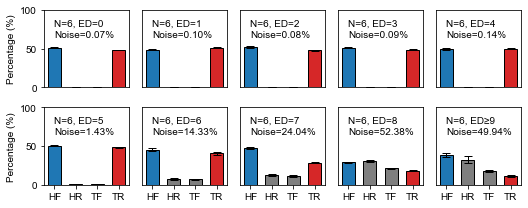

In [4]:
nrow, ncol = 2, 5
fig, axs = plt.subplots(nrow, ncol, figsize=(7.5, 3))
for ed in np.arange(ncol * nrow):
    rows = []
    for run in runs:
        row = []
        for location in "HT":
            for direction in "FR":
                row.append(data[run].get((ed, direction, location), 0))
        total = sum(row)
        row = np.array(row) * 100 / total
        rows.append(row)
    m = np.array(rows)
    ys = np.mean(m, axis=0)
    yerr = np.std(m, axis=0)
    xs = np.arange(4)
    colors = ["C0", "C7", "C7", "C3"]
    
    i1 = int(ed / ncol)
    i2 = ed % ncol
    ax = axs[i1][i2]
    plt.sca(ax)
    plt.bar(xs, ys, yerr=yerr, error_kw={"lw": 1, "capsize": 4}, color=colors, edgecolor="black", width=0.6)
    plt.ylim(0, 100)
    if i1 == 0:
        plt.xticks([])
    else:
        plt.xticks(xs, ["HF", "HR", "TF", "TR"])
    if i2 == 0:
        plt.ylabel("Percentage (%)")
    else:
        plt.yticks([])
    noise = 100 - (ys[0] + ys[3])
    x = 0
    if ed < nrow * ncol - 1:
        plt.text(x, 80, "N=%d, ED=%d" % (len(runs), ed))
    else:
        plt.text(x, 80, "N=%d, ED≥%d" % (len(runs), ed))
    plt.text(x, 65, "Noise=%.2f%%" % noise)
    plt.tight_layout(w_pad=0.5)
plt.savefig("figures/barcode_direct_loc.pdf", dpi=300)

## 3. Summary

In [5]:
rows = []
for run in runs:
    path = "../../1_NanoStrandSeq/results/demux/splitted/%s.log" % run
    lines = open(path).readlines()
    lines = list(filter(lambda line: "%" in line, lines))
    vs = [int(line.split()[-2]) for line in lines]
    rows.append(vs)
d = pd.DataFrame(rows, index=runs, columns=["Total", "TooShort", "NoDirection", "LargeED", "InvalidCell", "Pass"])
d["NoBarcode"] = d["NoDirection"] + d["LargeED"]
d = d[["Total", "TooShort", "NoBarcode", "InvalidCell", "Pass"]]
d = d.divide(d["Total"], axis=0)
d

,Total,TooShort,NoBarcode,InvalidCell,Pass
20220708_GM12878,1.0,0.019314,0.257811,0.000459,0.722416
20220708_GM12878R2,1.0,0.011476,0.231977,0.005172,0.751376
20220817_HG001,1.0,0.025135,0.330761,0.005265,0.638838
20220915_P1,1.0,0.010520,0.157393,0.002974,0.829113
20220916_P1,1.0,0.012543,0.180276,0.000687,0.806494
20220916_P2,1.0,0.007271,0.149826,0.015930,0.826972


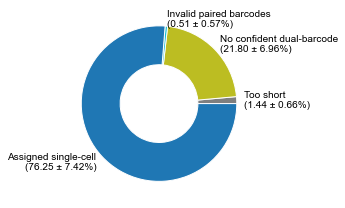

In [6]:
means = d.mean(axis=0)[1:] * 100
stds = d.std(axis=0)[1:] * 100

labels = [
    "Too short\n(%.2f ± %.2f%%)" % (means[0], stds[0]),
    "No confident dual-barcode\n(%.2f ± %.2f%%)" % (means[1], stds[1]),
    "Invalid paired barcodes\n(%.2f ± %.2f%%)" % (means[2], stds[2]),
    "Assigned single-cell\n(%.2f ± %.2f%%)" % (means[3], stds[3]),
]

plt.figure(figsize=(5, 3))
plt.pie(means, radius=1, 
        wedgeprops=dict(width=0.5, edgecolor='w'),
        colors=["C7", "C8", "C9", "C0"], labels=labels)
plt.tight_layout()
plt.savefig("figures/demultiplexing_summary.pdf", dpi=300)

# Reads of single-cell

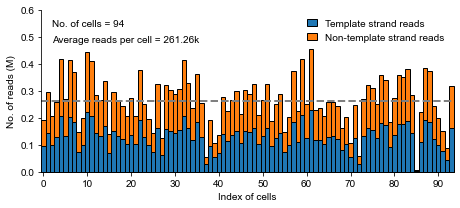

In [9]:
path = "../../1_NanoStrandSeq/results/demux/splitted/20220708_GM12878/reads.tsv"
dat = pd.read_csv(path, sep="\t")
dat = dat[dat["Cell"] != "unclassified"]

mean = dat["Reads"].mean() / 1e6
xs = np.arange(len(dat))
ys1 = dat["Forward"] / 1e6
ys2 = dat["Reverse"] / 1e6
ylim = 0.6 # max(ys1 + ys2) * 1.5

plt.figure(figsize=(6.5, 3))
plt.bar(xs, ys1, edgecolor="black", color="C0", width=1, lw=1, label="Template strand reads", clip_on=False)
plt.bar(xs, ys2, bottom=ys1, edgecolor="black", width=1, lw=1, color="C1", label="Non-template strand reads", clip_on=False)
plt.axhline(mean, color="grey", ls="--", lw=2)
plt.text(2, ylim * 0.9, "No. of cells = %d" % len(xs))
plt.text(2, ylim * 0.8, "Average reads per cell = %.2fk" % (mean * 1000))
plt.xticks(np.arange(0, len(xs), 10))
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, ylim)
plt.xlabel("Index of cells")
plt.ylabel("No. of reads (M)")
plt.legend(frameon=False, handlelength=1)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("figures/cell_read_number.pdf", dpi=300)

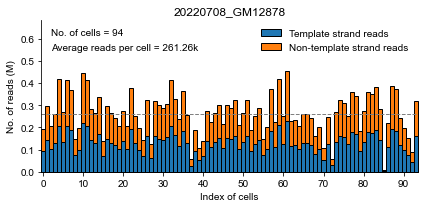

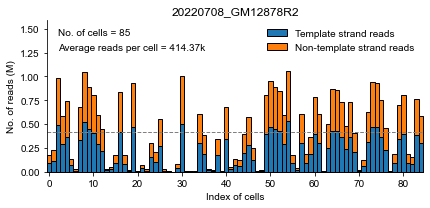

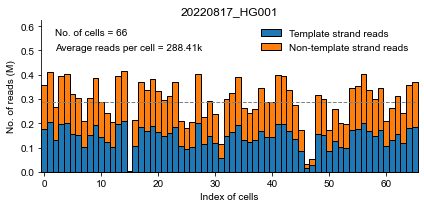

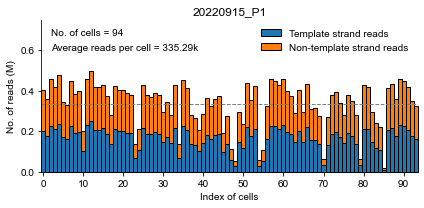

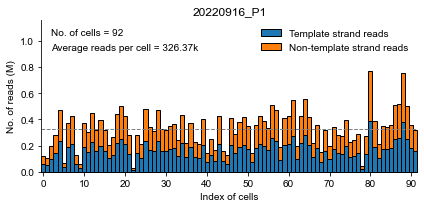

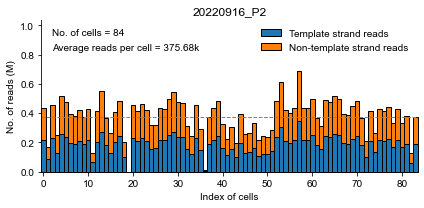

In [2]:
for run in runs:
    
    path = "../../1_NanoStrandSeq/results/demux/splitted/%s/reads.tsv" % run
    dat = pd.read_csv(path, sep="\t")
    dat = dat[dat["Cell"] != "unclassified"]

    mean = dat["Reads"].mean() / 1e6
    xs = np.arange(len(dat))
    ys1 = dat["Forward"] / 1e6
    ys2 = dat["Reverse"] / 1e6
    ylim = max(ys1 + ys2) * 1.5

    plt.figure(figsize=(6, 3))
    plt.title(run)
    plt.bar(xs, ys1, edgecolor="black", color="C0", width=1, lw=1, label="Template strand reads", clip_on=False)
    plt.bar(xs, ys2, bottom=ys1, edgecolor="black", width=1, lw=1, color="C1", label="Non-template strand reads", clip_on=False)
    plt.axhline(mean, color="grey", ls="--", lw=1)
    plt.text(2, ylim * 0.9, "No. of cells = %d" % len(xs))
    plt.text(2, ylim * 0.8, "Average reads per cell = %.2fk" % (mean * 1000))
    plt.xticks(np.arange(0, len(xs), 10))
    plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
    plt.ylim(0, ylim)
    plt.xlabel("Index of cells")
    plt.ylabel("No. of reads (M)")
    plt.legend(frameon=False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/cell_read_number.%s.pdf" % run, dpi=300)